In [41]:
import sys
import os
os.chdir("C:\\Users\\Zber\\Documents\\Dev_program\\OpenRadar")
import numpy as np
import mmwave.dsp as dsp
import mmwave.dsp.music as music
import mmwave.clustering as clu
from mmwave.dataloader import DCA1000
from demo.visualizer.visualize import ellipse_visualize
from FER.data_processing.mediapipe_facemesh_one import flm_detector, distance
from scipy import signal

from mmwave.dsp.utils import Window
import math
from FER.utils import parseConfigFile, arange_tx

from itertools import accumulate
from operator import add
from mmwave.dsp.cfar import ca

from scipy.signal import find_peaks, peak_widths
# import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')

from mpl_toolkits.mplot3d import Axes3D

plt.close('all')

DebugMode = True

if not DebugMode:
    import matplotlib

    matplotlib.use('Agg')

# plotting color
import matplotlib._color_data as mcd

tab_color = [mcd.TABLEAU_COLORS[name] for name in mcd.TABLEAU_COLORS]
extra_color = ['#acc2d9', '#56ae57', '#b2996e', '#a8ff04']
tab_color = tab_color + extra_color

# figpath = "C:/Users/Zber/Desktop/mmWave_figure"
figpath = "C:/Users/Zber/Desktop/SavedFigure"
configFileName = 'C:/Users/Zber/Desktop/mmWave Configuration/profile_3d_aop_3s.cfg'

In [42]:
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/OpenEyes_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/OpenMouth_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/RaiseCheek_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/OnlySurprise_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/OnlyBodyMotion_0_Raw_0.bin"
# adc_data_path = "D:\\Subjects\\S2\\Neutral_10_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/Surprise0.5m_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/1m_standing_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/Standing_1_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/empty_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/1m_standing&surprise_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/1m_standing&alwaysmove_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/1m_sit_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/sit_1m_move_1_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/stand_1m_move_1_Raw_0.bin"
adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/stand_1m_body_move_1_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/1m_ground_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/ground_1m_1_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/Surprise1m_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/SurpriseAndBodyMotion_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/1m_standing2ground_0_Raw_0.bin"

In [10]:
# num Antennas
numTxAntennas = 3
numRxAntennas = 4
# load configure parameters
config = parseConfigFile(configFileName)

# mmWave radar settings
numFrames = config['numFrames']
numADCSamples = config['numAdcSamples']
numLoopsPerFrame = config['numLoops']
numChirpsPerFrame = numTxAntennas * numLoopsPerFrame
numAngleBins = 64

# aoa related
VIRT_ELE_PAIRS = [[8, 2], [9, 3], [10, 4], [11, 5]]
VIRT_AZI_PAIRS = [[i for i in range(0, 8)]]

# azimuth
ANGLE_RES_AZI = 2
ANGLE_RANGE_AZI = 90
ANGLE_BINS_AZI = (ANGLE_RANGE_AZI * 2) // ANGLE_RES_AZI + 1
VIRT_ANT_AZI = 8

# elevation
ANGLE_RES_ELE = 5
ANGLE_RANGE_ELE = 30
ANGLE_BINS_ELE = (ANGLE_RANGE_ELE * 2) // ANGLE_RES_ELE + 1
VIRT_ANT_ELE = 2

BIN_RANG_S = 0
BIN_RANG_E = 256
BINS_PROCESSED = BIN_RANG_E - BIN_RANG_S
VIRT_ANT_AZI_INDEX = [i for i in range(0, 8)]
VIRT_ANT_ELE_INDEX = VIRT_ELE_PAIRS[2]

# data processing parameter
range_resolution, bandwidth = dsp.range_resolution(config['numAdcSamples'],
                                                    dig_out_sample_rate=config['digOutSampleRate'],
                                                    freq_slope_const=config['freqSlopeConst'])

doppler_resolution = dsp.doppler_resolution(bandwidth, start_freq_const=config['startFreq'],
                                            ramp_end_time=config['rampEndTime'],
                                            idle_time_const=config['idleTime'],
                                            num_loops_per_frame=config['numLoops'],
                                            num_tx_antennas=numTxAntennas)

print('Range Resolution: {:.2f}cm, Bandwidth: {:.2f}Ghz, Doppler Resolution: {:.2f}m/s'.format(
    range_resolution * 100, bandwidth / 1000000000, doppler_resolution))


Range Resolution: 4.22cm, Bandwidth: 3.56Ghz, Doppler Resolution: 0.43m/s


In [43]:
# (1) Reading in adc data
adc_data = np.fromfile(adc_data_path, dtype=np.int16)
adc_data = adc_data.reshape(numFrames, -1)
adc_data = np.apply_along_axis(DCA1000.organize_cli, 1, adc_data, num_chirps=numChirpsPerFrame,
                                num_rx=numRxAntennas, num_samples=numADCSamples)
print("Data Loaded!")

# (1) processing range data
# window types : Bartlett, Blackman p, Hanning p and Hamming
# range_data = dsp.range_processing(adc_data)
range_data = dsp.range_processing(adc_data, window_type_1d=Window.HANNING)
range_data = arange_tx(range_data, num_tx=numTxAntennas)

Data Loaded!


# range doppler processing


c:\Users\Zber\Documents\Dev_program\OpenRadar\mmwave\dsp\doppler_processing.py:196: RuntimeWarning: divide by zero encountered in log2
  fft2d_log_abs = np.log2(np.abs(fft2d_out))


C:\Users\Zber\anaconda3\envs\Emo\lib\site-packages\matplotlib\image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
C:\Users\Zber\anaconda3\envs\Emo\lib\site-packages\matplotlib\image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


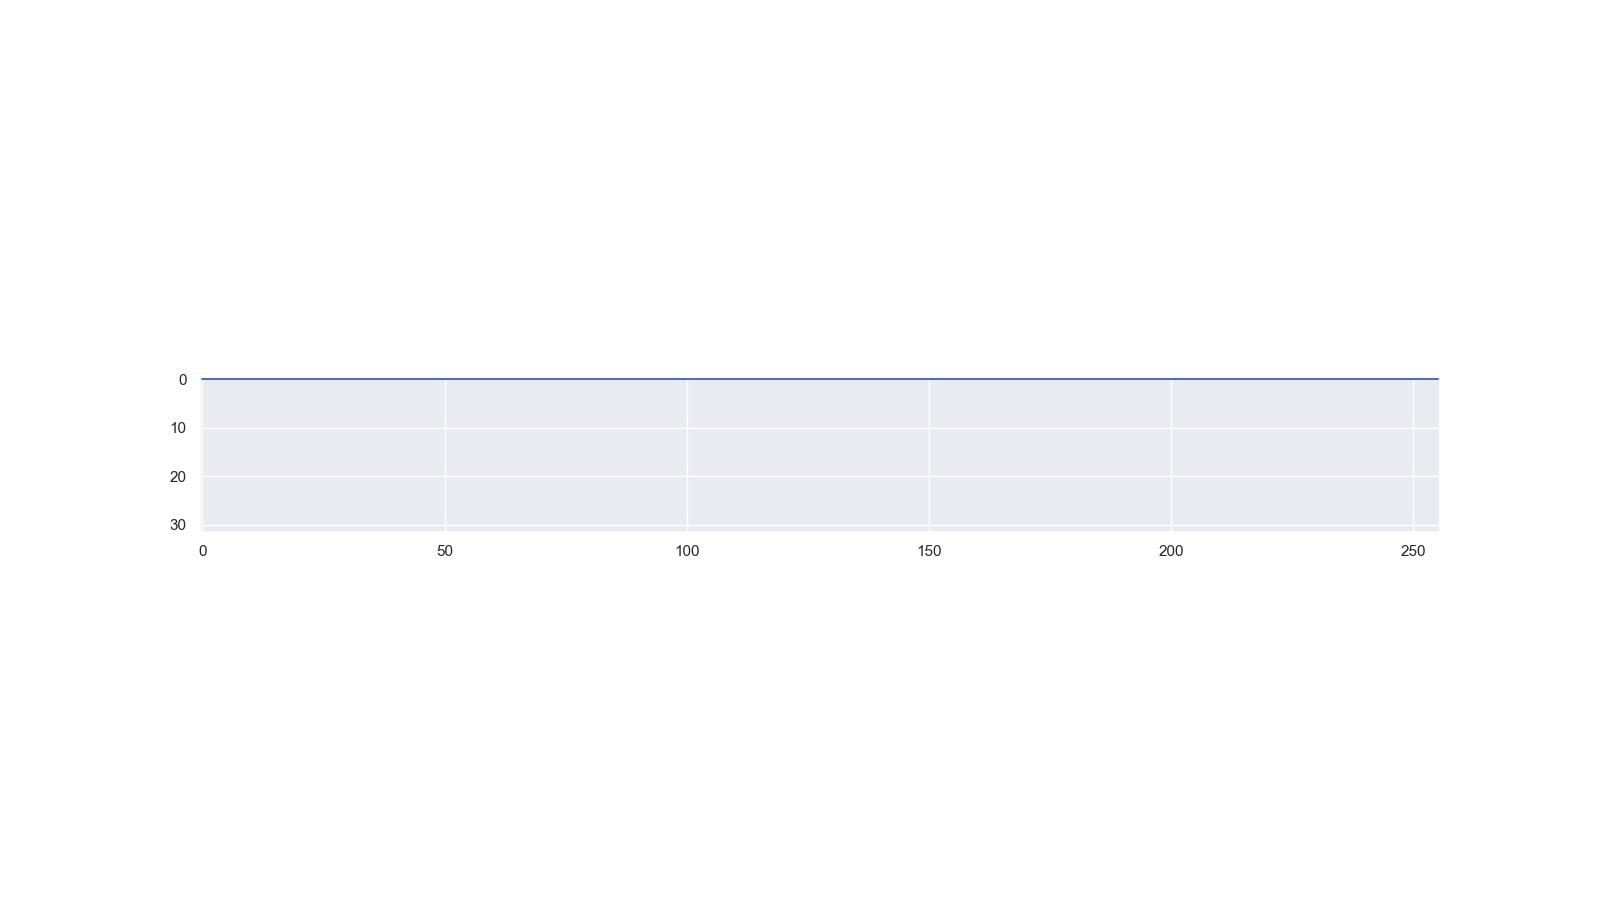

In [47]:
%matplotlib widget
# %matplotlib inline
fig, axes = plt.subplots(1, 1, figsize=(16, 9))
det_matrix, aoa_input = dsp.doppler_processing_frame(range_data, num_tx_antennas=numTxAntennas,
                                                    clutter_removal_enabled=True,
                                                    window_type_2d=Window.HAMMING,
                                                    accumulate=True)

det_matrix_vis = np.fft.fftshift(det_matrix, axes=2)
det_matrix_vis_mean = np.mean(det_matrix_vis[:, :, :], axis=0)
# det_matrix_vis_mean = det_matrix_vis[54, :, :]
bin_data = det_matrix_vis_mean[:, 17] + det_matrix_vis_mean[:, 15]

peak_data = ca(bin_data, guard_len=2, noise_len=4, l_bound=8)

axes.plot(peak_data)

# plt.imshow(np.abs(det_matrix_vis_mean.T), cmap=plt.cm.jet)
axes.imshow(np.abs(det_matrix_vis_mean.T), cmap=plt.get_cmap('jet'))


In [32]:
det_matrix.shape

(300, 256, 96)

In [22]:
# standing
bin_start = 25
bin_end = 30
num_vec, steering_vec = dsp.gen_steering_vec(ANGLE_RANGE_AZI, ANGLE_RES_AZI, VIRT_ANT_AZI)

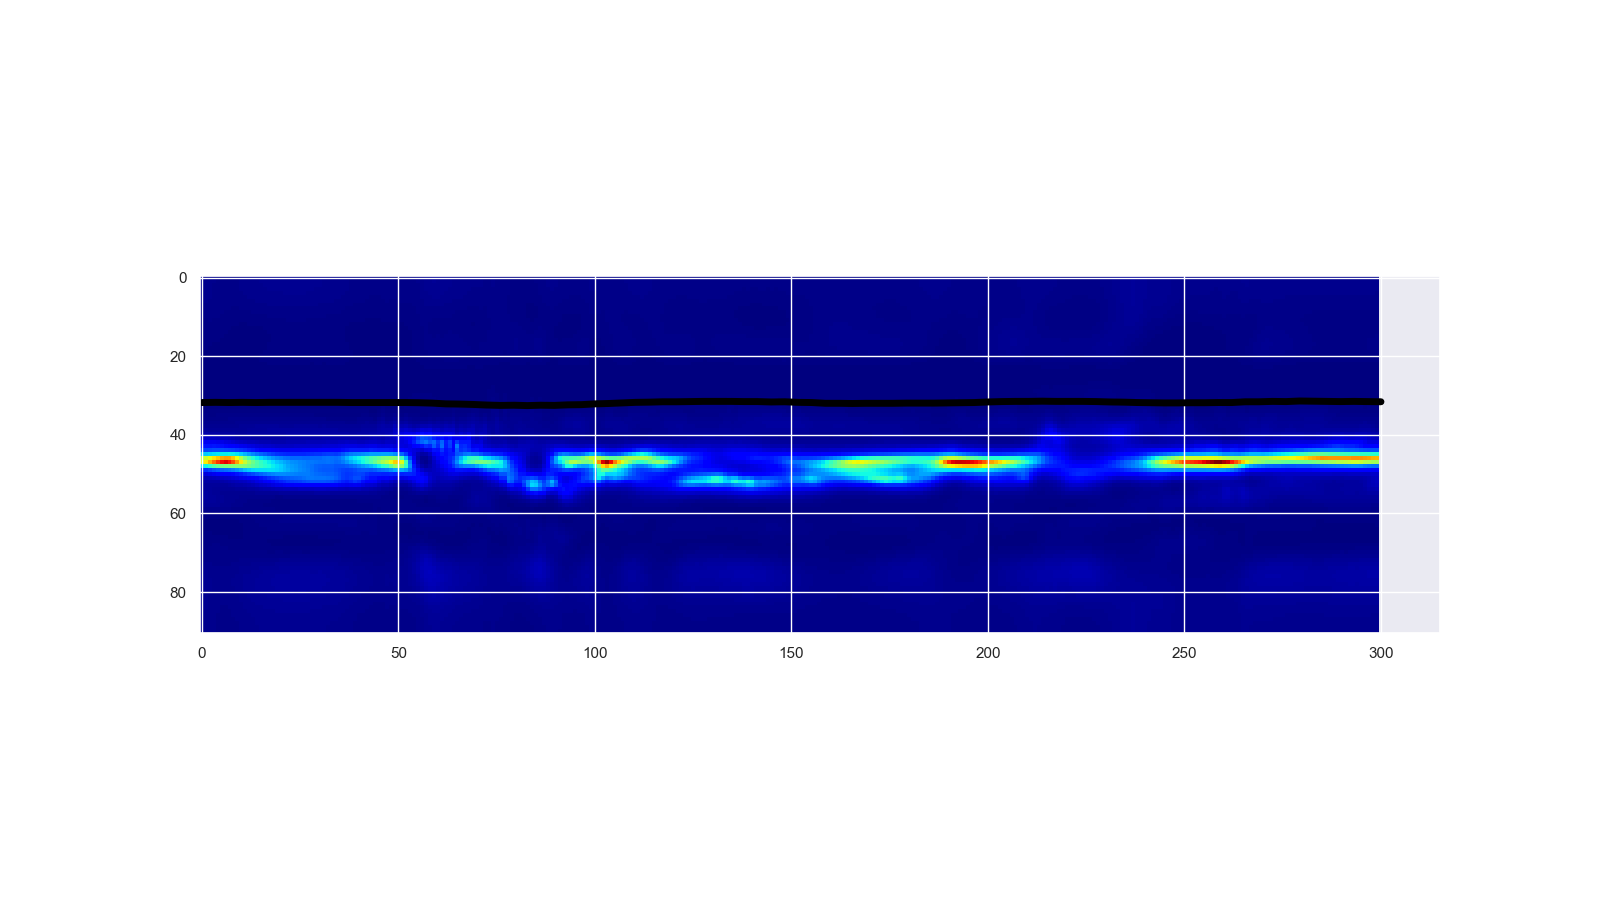

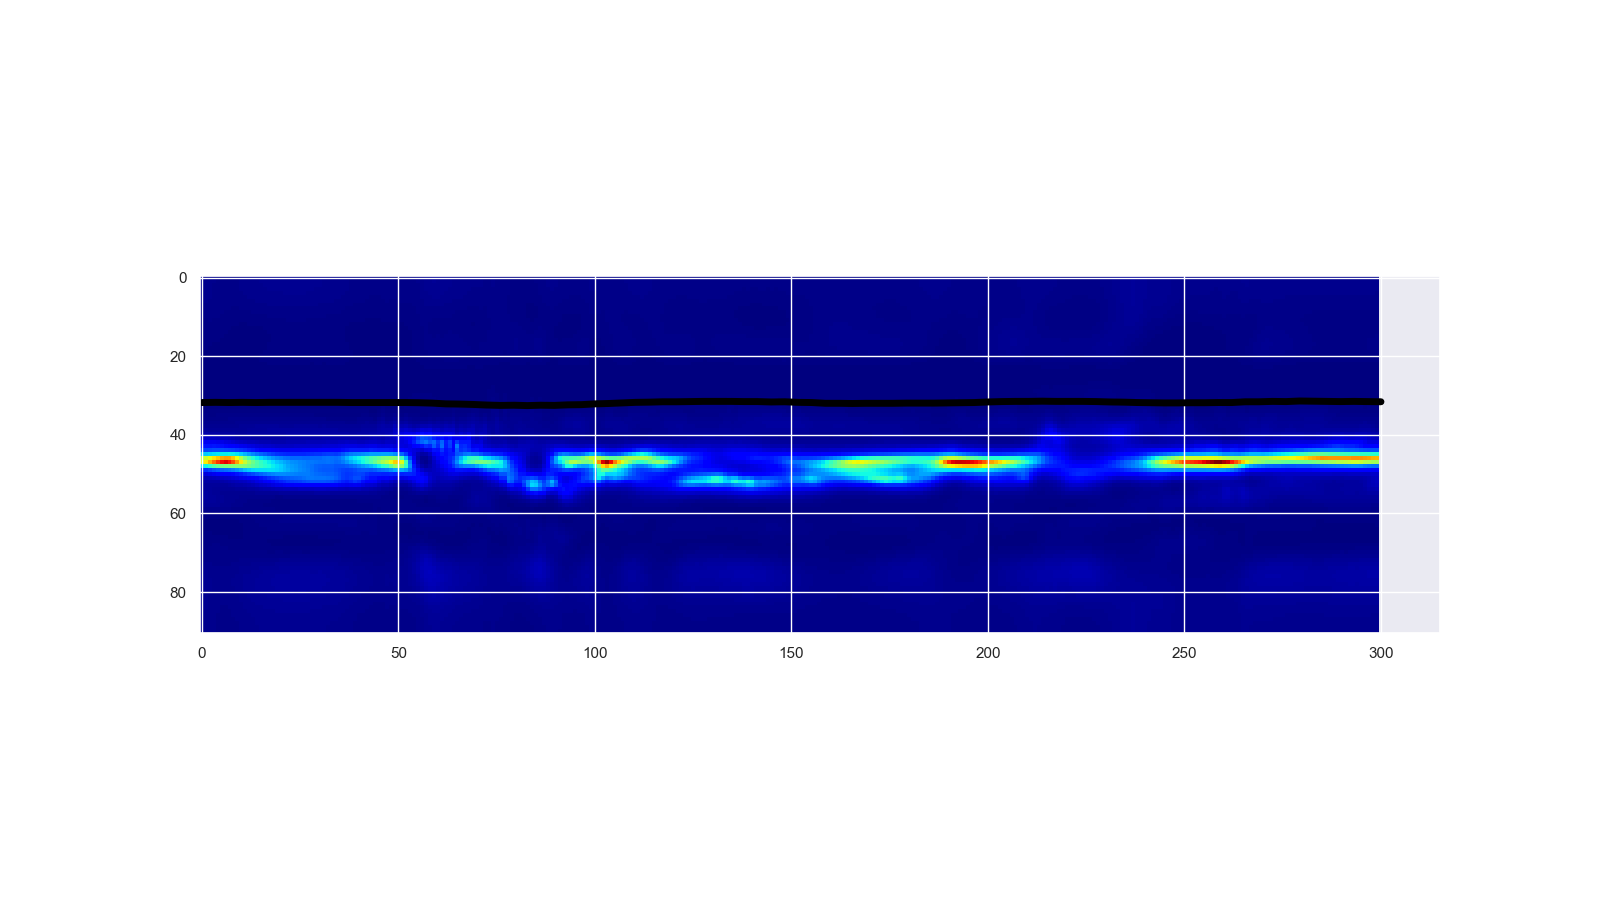

In [29]:
fig1, axes1 = plt.subplots(1, 1, figsize=(16, 9))
time_angle = np.zeros((ANGLE_BINS_AZI, 300))
for i in range(0, 300):
    for r in range(bin_start, bin_end):
        # chirp_data = np.mean(va_data[5, :, VIRT_ANT_AZI_INDEX, i:i + 1], axis=-1)
        chirp_data = range_data[i, :, VIRT_ANT_AZI_INDEX, r]
        # chirp_data = np.angle(chirp_data)
        # steering_vec = np.angle(steering_vec)
        # chirp_data = va_data[50, :, VIRT_ANT_AZI_INDEX, i]
        time_angle[:, i] += music.aoa_music_1D(steering_vec, chirp_data, 1)

        # time_angle[:, i] += music.aoa_root_music_1D(steering_vec, chirp_data, 1)

        # capon_angle, beamWeights = dsp.aoa_capon(chirp_data, steering_vec, magnitude=True)
        # time_angle[:, i] = time_angle[:, i] + capon_angle

    # music_specturm = music.aoa_root_music_1D(steering_vec, chirp_data, 1)
    # music_specturm = music.aoa_esprit(steering_vec.T, chirp_data, 2, 2)

#
# np.save("C:/Users/Zber/Desktop/Subjects/Test/empty_data", time_angle)
# empty_angle = np.load("C:/Users/Zber/Desktop/Subjects/Test/empty_data.npy")

# new_angle = time_angle-empty_angle

# fig, axes = plt.subplots(1, 1, figsize=(50, 90))
# axes.imshow(new_angle, cmap=plt.cm.jet)

axes1.imshow(time_angle, cmap=plt.cm.jet)

# angle = np.abs(60 - np.load("C:/Users/Zber/Desktop/Subjects/Test/image_angle.npy"))
# angle = np.abs(60 - np.load("C:/Users/Zber/Desktop/Subjects/Test/image_angle_standing&surprise.npy"))
# image_angle = np.load("C:/Users/Zber/Desktop/Subjects/Test/image_angle_1m_sit.npy")
# image_angle = np.load("C:/Users/Zber/Desktop/Subjects/Test/image_angle_sit_1m_move.npy")
image_angle = np.load("C:/Users/Zber/Desktop/Subjects/Test/image_angle_stand_1m_move.npy")
# image_angle = np.load("C:/Users/Zber/Desktop/Subjects/Test/image_angle_ground_1m_1.npy")

# image_angle = np.load("C:/Users/Zber/Desktop/Subjects/Test/image_angle_standing_1.npy")
image_angle = (image_angle - 35 + 90) / ANGLE_RES_AZI
angle = image_angle
x = np.linspace(0, 300, len(angle))
axes1.plot(x, angle, c="black", lw=5)

fig1.show()
